In [1]:
import numpy as np
from hmmlearn import hmm
from hmmlearn.base import ConvergenceMonitor
import matplotlib.pyplot as plt
from matplotlib import colormaps
import matplotlib.colors as colors
from static_probabilities import TRANSITION_PROBABILITIES_12UL, EMISSION_PROBABILITIES_12UL, START_PROBABILITIES_12UL
from time import time
from collections import Counter

In [2]:
def plot_matrix(matrix):
    plt.imshow(matrix, interpolation='none', cmap=colormaps["autumn"], norm=colors.PowerNorm(0.1))
    for (j,i),label in np.ndenumerate(matrix):
        plt.text(i,j,round(label, 3),ha='center',va='center')
    plt.show()

In [3]:
from requests import get as _get
from os.path import isfile
import json

TELRAAM_URL = 'http://localhost:8080'

# Fetch data from cache or Telraam
def get(url: str) -> list:
    l = None
    if isfile(f"data/{url}.json"):
        with open(f"data/{url}.json", "r") as file:
            l = json.loads(file.read())
    else:
        l = _get(f'{TELRAAM_URL}/{url}').json()
        with open(f"data/{url}.json", "w") as file:
            file.write(json.dumps(l))
    
    print(l[0])
    print(f'Fetched {len(l)} items')
    return l

In [4]:
detections = sorted(get('detection'), key=lambda x: x["timestamp"])

{'id': 4223721, 'batonId': 18, 'stationId': 8, 'rssi': -96, 'battery': 95.0, 'uptimeMs': 2034314, 'remoteId': 3825, 'timestamp': 1651041379481}
Fetched 2034655 items


In [5]:
batons = get('baton')

{'id': 2, 'name': 'O', 'mac': '5a:45:55:53:00:00'}
Fetched 22 items


In [6]:
baton_switchovers = sorted(get('batonswitchover'), key=lambda x: x["timestamp"])

{'id': 1, 'teamId': 1, 'previousBatonId': None, 'newBatonId': 23, 'timestamp': 1651012254359}
Fetched 73 items


In [7]:
stations = sorted(get('station'), key=lambda x: x["id"])

{'id': 10, 'name': 'station 5', 'distanceFromStart': 219.0, 'isBroken': False, 'url': 'http://172.12.50.105:8000'}
Fetched 7 items


In [8]:
teams = get('team')

{'id': 1, 'name': 'HILOK', 'batonId': 18}
Fetched 17 items


In [9]:
laps = get('accepted-laps')

{'id': 5096, 'teamId': 7, 'lapSourceId': 1, 'timestamp': 1651039200000}
Fetched 7987 items


# Processing data

In [10]:
team_detections: dict[int, list] = {team["id"]: [] for team in teams}
team_by_id: dict[int, dict] = {team["id"]: team for team in teams}
baton_team: dict[int, dict] = {}
event_begin = 1651042800000
event_end = 1651086000000

switchover_index = 0
for detection in detections:
    while switchover_index < len(baton_switchovers) and baton_switchovers[switchover_index]["timestamp"] < detection[
        "timestamp"]:
        switchover = baton_switchovers[switchover_index]
        baton_team[switchover["newBatonId"]] = team_by_id[switchover["teamId"]]
        if switchover["previousBatonId"] in baton_team:
            del baton_team[switchover["previousBatonId"]]
        switchover_index += 1

    if detection["batonId"] in baton_team:
        if event_begin <= detection['timestamp'] <= event_end and detection['rssi'] > -80:
            current_detections = team_detections[baton_team[detection["batonId"]]["id"]]
            if len(current_detections) > 0 and current_detections[-1]["timestamp"] == detection["timestamp"]:
                if current_detections[-1]["rssi"] < detection["rssi"]:
                    current_detections[-1] = detection
            else:
                current_detections.append(detection)

In [11]:
# Detections per team
print({k: len(v) for k, v in team_detections.items()})

{1: 56394, 3: 38904, 4: 27966, 5: 49442, 8: 49201, 9: 34607, 10: 45465, 11: 37840, 12: 37246, 13: 36572, 14: 36385, 17: 23743, 7: 35702, 22: 34502, 6: 34625, 2: 30716, 16: 30937}


# Fitted Viterbi Lapper

## Fitting HMM parameters

In [12]:
station_to_emission = {v: k for k, v in enumerate([station["id"] for station in stations])}
data = [[[station_to_emission[detection["stationId"]]] for detection in team_detections[i]] for i in team_detections.keys()]
np_data = np.concatenate(data)
lengths = [len(x) for x in data]

model = hmm.CategoricalHMM(n_components=7, n_iter=1000, init_params="",implementation="scaling")
model.transmat_ = TRANSITION_PROBABILITIES_12UL.copy()
model.emissionprob_ = EMISSION_PROBABILITIES_12UL.copy()
model.startprob_ = START_PROBABILITIES_12UL.copy()
model.monitor_ = ConvergenceMonitor(model.monitor_.tol, model.monitor_.n_iter, model.monitor_.verbose)

model.fit(np_data, lengths)
model.monitor_

ConvergenceMonitor(
    history=[-352466.33020628034, -246001.52156292045, -243917.0494456806, -243714.08627809762, -243685.0659106317, -243679.83841589047, -243678.47983223136, -243677.9304709439, -243677.63284763842, -243677.44518409466, -243677.31739838666, -243677.22667935523, -243677.16064389385, -243677.11178112816, -243677.0752086567, -243677.04760591415, -243677.0266422333, -243677.01064455326, -243676.99839122948, -243676.98897844265],
    iter=20,
    n_iter=1000,
    tol=0.01,
    verbose=False,
)

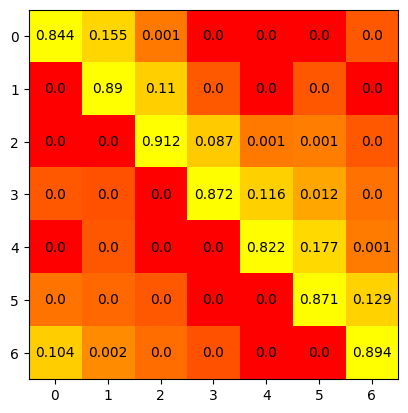

In [13]:
plot_matrix(model.transmat_)

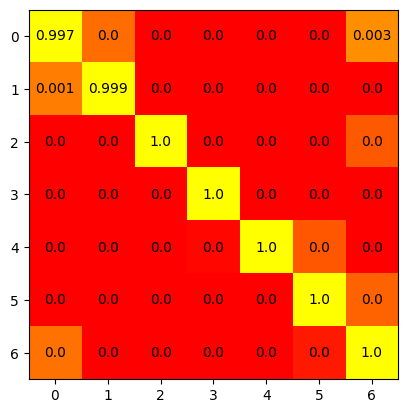

In [14]:
plot_matrix(model.emissionprob_)

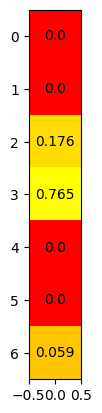

In [15]:
plot_matrix(np.array([model.startprob_]).reshape((7,1)))

## Counting Laps (HMM)

In [16]:
start = time()

tranlate_path = [0,1,2,3,4,5,6]

start_segment = list(model.startprob_).index(np.max(model.startprob_))
counts = []
half = 7//2

hmm_team_laps: dict[int, list[int]] = {}

for team in teams:
    filtered_detections = [detection for detection in team_detections[team["id"]]]
    _, path = model.decode(np.array([[station_to_emission[detection["stationId"]] for detection in filtered_detections]]))
    path = list(map(lambda x: tranlate_path[x], path))
    count = 0
    prev = path[0]
    lap_times = []
    for i, segment in enumerate(path[1:]):
        delta = half - (half - (segment - prev)) % 7
        if delta > 0 and prev > segment:
            count += 1
            lap_times.append(filtered_detections[i+1]["timestamp"])
        elif delta < 0 and prev < segment:
            count -= 1
            if len(lap_times) > 0:
                print(f"popping lap for team {team['name']}")
                lap_times.pop()
        prev = segment

    counts.append((team["name"], count))
    hmm_team_laps[team['name']] = lap_times

counts = sorted(counts, key=lambda x:x[1])
hmm_counts = counts

labels = [l for l, _ in counts]
counts = [c for _, c in counts]


print(f'Took: {time() - start}')

popping lap for team Lila - VDK
popping lap for team Lila - VDK
popping lap for team HK
popping lap for team Antilopen
popping lap for team Antilopen
popping lap for team VGK
Took: 0.6129014492034912


## Counting laps (Simple lapper)

In [17]:
simple_team_laps = {}

# Sort stations in order they are in the field: so first station after start line is at idx 0
sorted_stations = sorted(stations, key=lambda s: s['distanceFromStart'])

# Dictionary of station id -> station position (index)
mapping_station_to_position = {s['id']: idx for idx, s in enumerate(sorted_stations)}

# Amount of stations between from_station and to_station, counted when going forward and when going backward
def path_distance(from_station, to_station):
    forward_distance = (to_station - from_station) % len(mapping_station_to_position)
    backward_distance = (from_station - to_station) % len(mapping_station_to_position)
    return forward_distance, backward_distance

# Example: there are two ways to go from station 1 to station 2:
#  1 station forwards
#  6 stations back (assuming that there are 7 stations in total)
assert path_distance(1, 2) == (1, 6)

# Is the finish line between from_station and to_station when running forwards?
def is_start_between(from_station, to_station):
    return from_station > to_station

# Interval during which detections are grouped (in ms)
interval_time = 2000

for team in teams:
    lap_times = []

    last_station_position = 0
    
    # Station that is used for the current interval
    current_station_time = 0
    current_station_rssi = -float('inf')
    current_station_position = 0
    
    # This RSSI filtering is not needed (and maybe even kind of worsens precision) but
    # 1. it can help with performance (you have to process less detections)
    # 2. it was also added because the data import step higher in this notebook also does
    #    RSSI filtering, so this should be documented
    # For production, I'd recommend removing it
    filtered_detections = [d for d in team_detections[team["id"]] if d['rssi'] > -80]
    
    for detection in filtered_detections:
        # Map station id from detection to station position
        station_position = mapping_station_to_position[detection['stationId']]
        if detection['timestamp'] - current_station_time < interval_time:
            # We're still in the same interval
            
            # Use the station with the highest RSSI from this interval
            if detection['rssi'] > current_station_rssi:
                current_station_position = station_position
                current_station_rssi = detection['rssi']
        else:
            # We're in a new interval, use the detection with the highest RSSI to update trajectory
            
            _forward_dist, backward_dist = path_distance(last_station_position, current_station_position)
            # If we've not gone backwards a small bit, assume we've gone forwards
            if not (backward_dist <= 2):
                if is_start_between(last_station_position, current_station_position):
                    # Add lap if we passed the start line
                    lap_times.append(detection["timestamp"])
                last_station_position = current_station_position
            # Prepare new interval
            current_station_time = detection['timestamp']
            current_station_position = mapping_station_to_position[detection['stationId']]
            current_station_rssi = detection['rssi']
    # Save result for team
    simple_team_laps[team['name']] = lap_times


## Calculating difference

### Difference with official count

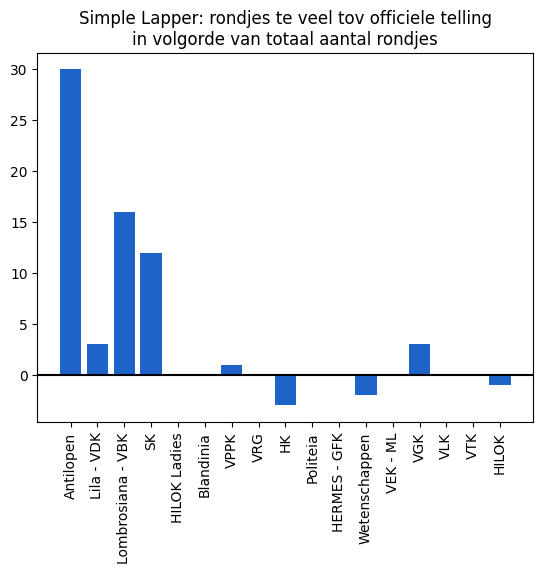

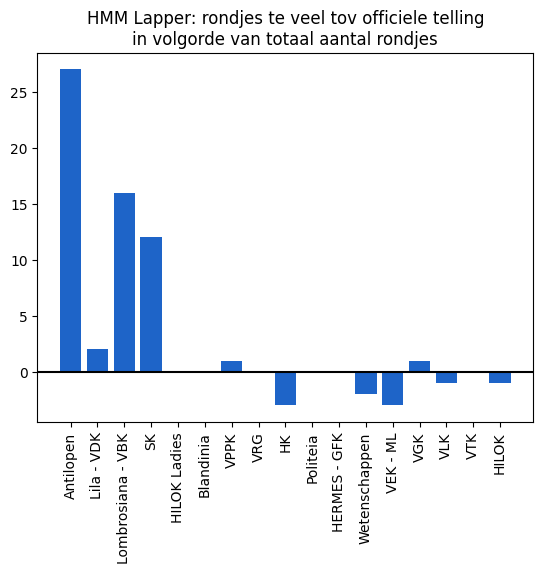

{'HILOK': -1,
 'VLK': 0,
 'Wetenschappen': -2,
 'VRG': 0,
 'HERMES - GFK': 0,
 'Lila - VDK': 3,
 'VPPK': 1,
 'VEK - ML': 0,
 'HK': -3,
 'Lombrosiana - VBK': 16,
 'Blandinia': 0,
 'Antilopen': 30,
 'Politeia': 0,
 'HILOK Ladies': 0,
 'VGK': 3,
 'VTK': 0,
 'SK': 12}

In [18]:
# Mapping from team name to team object
name_to_team = {team['name']: team for team in teams}

# Final 'official' count
urenloop_count_json = [{"count": 875, "team": {"id": 1, "name": "HILOK"}}, {"count": 777, "team": {"id": 3, "name": "VLK"}}, {"count": 669, "team": {"id": 4, "name": "Wetenschappen"}}, {"count": 629, "team": {"id": 5, "name": "VRG"}}, {"count": 649, "team": {"id": 8, "name": "HERMES - GFK"}}, {"count": 553, "team": {"id": 9, "name": "Lila - VDK"}}, {"count": 626, "team": {"id": 10, "name": "VPPK"}}, {"count": 730, "team": {"id": 11, "name": "VEK - ML"}}, {"count": 631, "team": {"id": 12, "name": "HK"}}, {"count": 565, "team": {"id": 13, "name": "Lombrosiana - VBK"}}, {"count": 622, "team": {"id": 14, "name": "Blandinia"}}, {"count": 528, "team": {"id": 17, "name": "Antilopen"}}, {"count": 642, "team": {"id": 7, "name": "Politeia"}}, {"count": 613, "team": {"id": 22, "name": "HILOK Ladies"}}, {"count": 740, "team": {"id": 6, "name": "VGK"}}, {"count": 868, "team": {"id": 2, "name": "VTK"}}, {"count": 577, "team": {"id": 16, "name": "SK"}}]
urenloop_count = {entry["team"]["name"]: entry["count"] for entry in urenloop_count_json}

# Simple algorithm
simple_diff = {name: len(laps)-urenloop_count[name] for name, laps in simple_team_laps.items()}
simple_diff_sorted = sorted(simple_diff.items(), key=lambda t: urenloop_count.get(t[0]))
x, y = zip(*simple_diff_sorted)
plt.bar(x, y, color='#1E64C8')
plt.xticks(rotation=90)
plt.title("Simple Lapper: rondjes te veel tov officiele telling\nin volgorde van totaal aantal rondjes")
plt.axhline(y=0, color='black')
plt.show()

# Francis HMM
hmm_diff = {name: len(laps)-urenloop_count[name] for name, laps in hmm_team_laps.items()}
hmm_diff_sorted = sorted(hmm_diff.items(), key=lambda t: urenloop_count.get(t[0]))
x, y = zip(*hmm_diff_sorted)
plt.bar(x, y,  color='#1E64C8')
plt.xticks(rotation=90)
plt.title("HMM Lapper: rondjes te veel tov officiele telling\nin volgorde van totaal aantal rondjes")
plt.axhline(y=0, color='black')
plt.show()

simple_diff

## Lap times

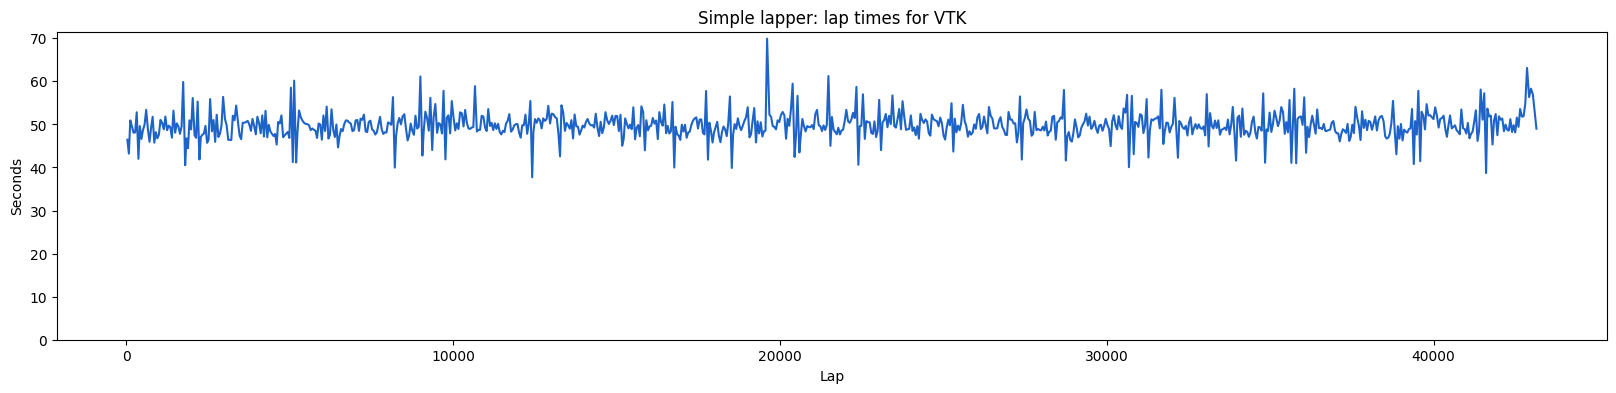

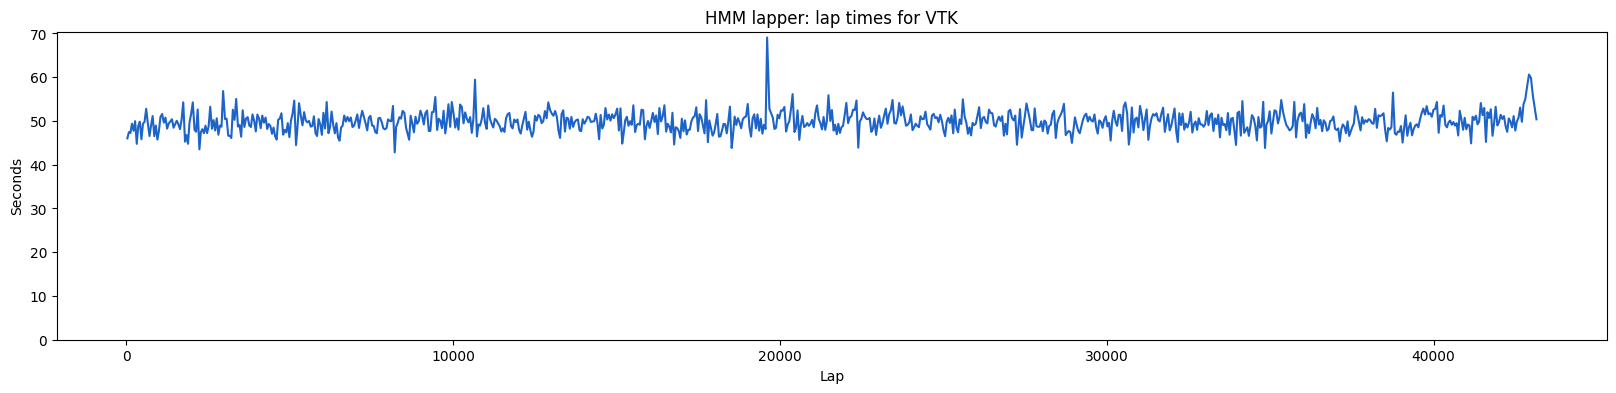

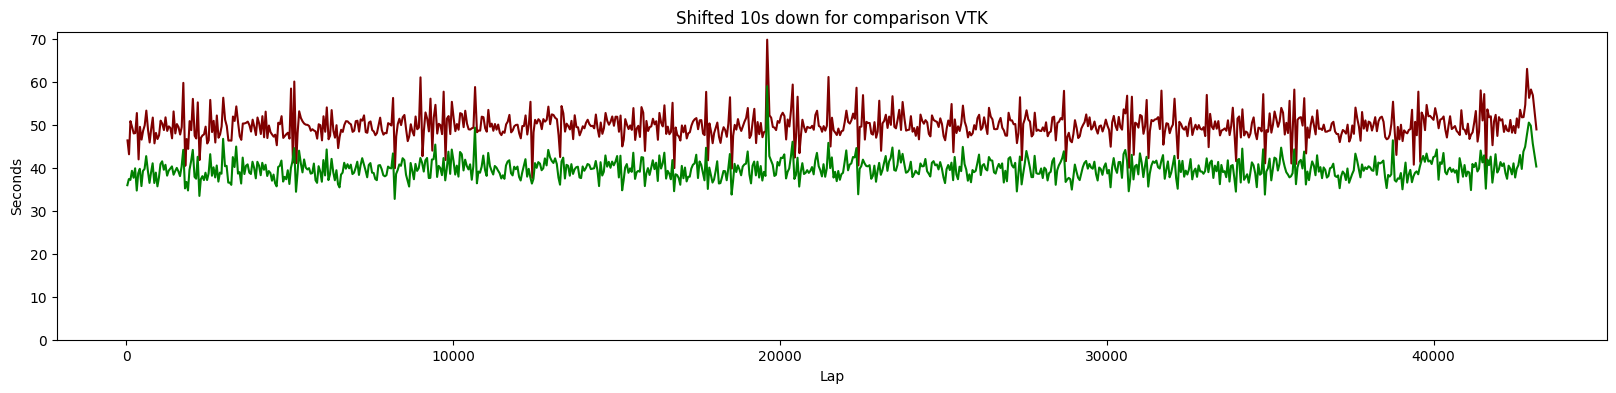

868
868


In [19]:
inspected_team = 'VTK'
simple_relative_laptimes = []
prev = simple_team_laps[inspected_team][0]
for t in simple_team_laps[inspected_team][1:]:
    simple_relative_laptimes.append((t-prev)/1000)
    if not (20 < (t-prev)/1000 < 75):
        print(prev, t)
    prev = t

plt.figure(figsize=(20, 4))
plt.ylabel("Seconds")
plt.xlabel("Lap")
plt.title("Simple lapper: lap times for " + inspected_team)
plt.plot((np.array(simple_team_laps[inspected_team][:-1])-event_begin)/1000, np.array(simple_relative_laptimes),color='#1E64C8')
plt.ylim(bottom=0)
plt.show()

hmm_relative_laptimes = []
prev = hmm_team_laps[inspected_team][0]
for t in hmm_team_laps[inspected_team][1:]:
    hmm_relative_laptimes.append((t-prev)/1000)
    prev = t

plt.figure(figsize=(20, 4))
plt.ylabel("Seconds")
plt.xlabel("Lap")
plt.title("HMM lapper: lap times for " + inspected_team)
plt.plot((np.array(hmm_team_laps[inspected_team][:-1])-event_begin)/1000, np.array(hmm_relative_laptimes),color='#1E64C8')
plt.ylim(bottom=0)
plt.show()

plt.figure(figsize=(20, 4))
plt.ylabel("Seconds")
plt.xlabel("Lap")
plt.title("Shifted 10s down for comparison " + inspected_team)
plt.plot((np.array(simple_team_laps[inspected_team][:-1])-event_begin)/1000, np.array(simple_relative_laptimes),color='#800000')
plt.plot((np.array(hmm_team_laps[inspected_team][:-1])-event_begin)/1000, np.array(hmm_relative_laptimes)-10,color='#008000')
plt.ylim(bottom=0)
plt.show()

print(len(simple_team_laps[inspected_team]))
print(len(hmm_team_laps[inspected_team]))


## Ilion graph (station RSSI vs time)

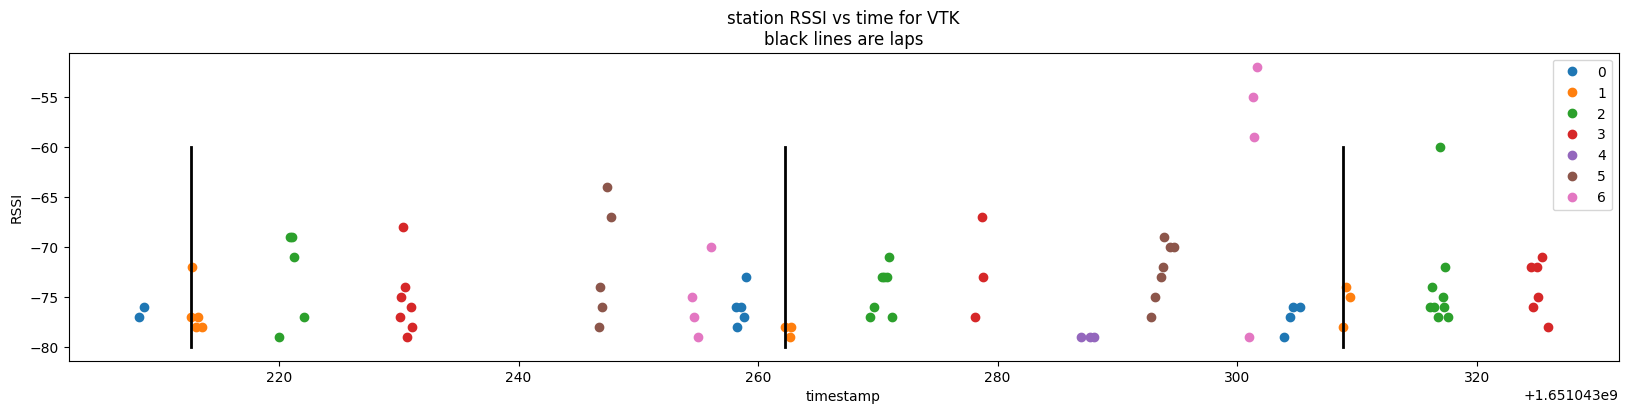

In [20]:
begin_timestamp = 1651043265079
end_timestamp = 1651043278901
begin = begin_timestamp - 1*60*1000 # one minute
end = end_timestamp + 1*60*1000     # one minute

plt.figure(figsize=(20, 4))
plt.title(f"station RSSI vs time for {inspected_team}\nblack lines are laps")
plt.ylabel("RSSI")
plt.xlabel("timestamp")

for station in sorted(stations, key=lambda x: x["id"]):
    filtered_by_station = [detection for detection in team_detections[name_to_team[inspected_team]['id']] if detection["stationId"] == station["id"]]
    filtered_by_time = [d for d in filtered_by_station if begin < d['timestamp'] < end]
    
    plt.plot(
        [(detection["timestamp"])/1000 for detection in filtered_by_time],
        [detection["rssi"] for detection in filtered_by_time],
        'o', label=mapping_station_to_position[station['id']]
    )
for laptime in simple_team_laps[inspected_team]:
    if begin < laptime < end:
        plt.plot([laptime/1000, laptime/1000], [-80, -60], 'k-', lw=2)

plt.legend()
plt.show()